/home/jc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/jc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
/home/jc/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


>CART 0.848 (0.005)


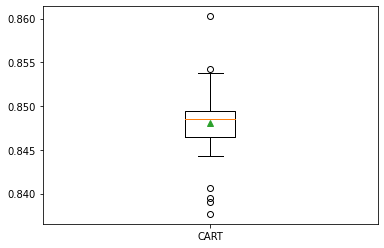

In [1]:
# spot check machine learning algorithms on the adult imbalanced dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# load the dataset
def load_dataset(full_path):
	# load the dataset as a numpy array
	dataframe = read_csv(full_path, header=None, na_values='?')
	# drop rows with missing
	dataframe = dataframe.dropna()
	# split into inputs and outputs
	last_ix = len(dataframe.columns) - 1
	X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
	# select categorical and numerical features
	cat_ix = X.select_dtypes(include=['object', 'bool']).columns
	num_ix = X.select_dtypes(include=['int64', 'float64']).columns
	# label encode the target variable to have the classes 0 and 1
	y = LabelEncoder().fit_transform(y)
	return X.values, y, cat_ix, num_ix

# evaluate a model
def evaluate_model(X, y, model):
	# define evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# define models to test
def get_models():
	models, names = list(), list()
	# CART
	models.append(DecisionTreeClassifier())
	names.append('CART')
	# SVM
	models.append(SVC(gamma='scale'))
	names.append('SVM')
	# Bagging
	models.append(BaggingClassifier(n_estimators=100))
	names.append('BAG')
	# RF
	models.append(RandomForestClassifier(n_estimators=100))
	names.append('RF')
	# GBM
	models.append(GradientBoostingClassifier(n_estimators=100))
	names.append('GBM')
	return models, names
file = 'Adult_NotNA_'
# define the location of the dataset
full_path = f'../GeneralDatasets/Csv/{file}.csv'
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path)
# define models
models, names = get_models()
results = list()
total_texts = []
# evaluate each model
for i in range(len(models)):
	# define steps
	steps = [('c',OneHotEncoder(handle_unknown='ignore'),cat_ix), ('n',MinMaxScaler(),num_ix)]
	# one hot encode categorical, normalize numerical
	ct = ColumnTransformer(steps)
	# wrap the model i a pipeline
	pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
	# evaluate the model and store results
	scores = evaluate_model(X, y, pipeline)
	results.append(scores)
	# summarize performance
	print_text = '>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores))
	total_texts.append(print_text)
	print(print_text)
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.savefig(f"./experiments/metadata_{file}.png)
# Write the results to file

In [3]:
with open(f"./experiments/metadata_{file}.txt", 'w+') as f:
            f.write(f"Results: {results} \n \n")
            f.write(f"TEst Output: {total_texts} \n \n")